<a href="https://colab.research.google.com/github/Drone-Research-Lab/ArtificialPainPathway/blob/main/artificial_pain_pathway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ABSTRACT

---

The neural mechanisms involved in pain perception consists of a pathway which carry signals from the periphery to the cerebral cortex. First-order pain neurons transduces the potentially damaging stimuli detected by the sensorial extremes into long-ranging electrical signals that are transmitted to higher order neurons where the organization is more heterarchical, especially in the cerebral cortex. However, the first order neurones, as their name states,  have a degree of branching which clearly identifies them as hierarchical elements in the arrangement of pain pathway. This research aims to develop an artificial neural pain pathway that mimics this biological process, in particular the first order neurones. First, the research proposes the periodogram method on the condition monitoring data with a minor malfunction and operational damage. As the pain is associated with actual or potential tissue damage, using such data from a machinery system can provide insights which can be used to improve the computational effectiveness. Then, a one-dimensional convolutional neural network model is introduced to represent the second and third orders of the pain pathway. The results provided support for this framework with an increased classification competence and performance. The research findings found clear support for studying the similarities between the major components of biological information processing of tissue damage and statistical signal processing for damage estimation.






# Graphical Abstract


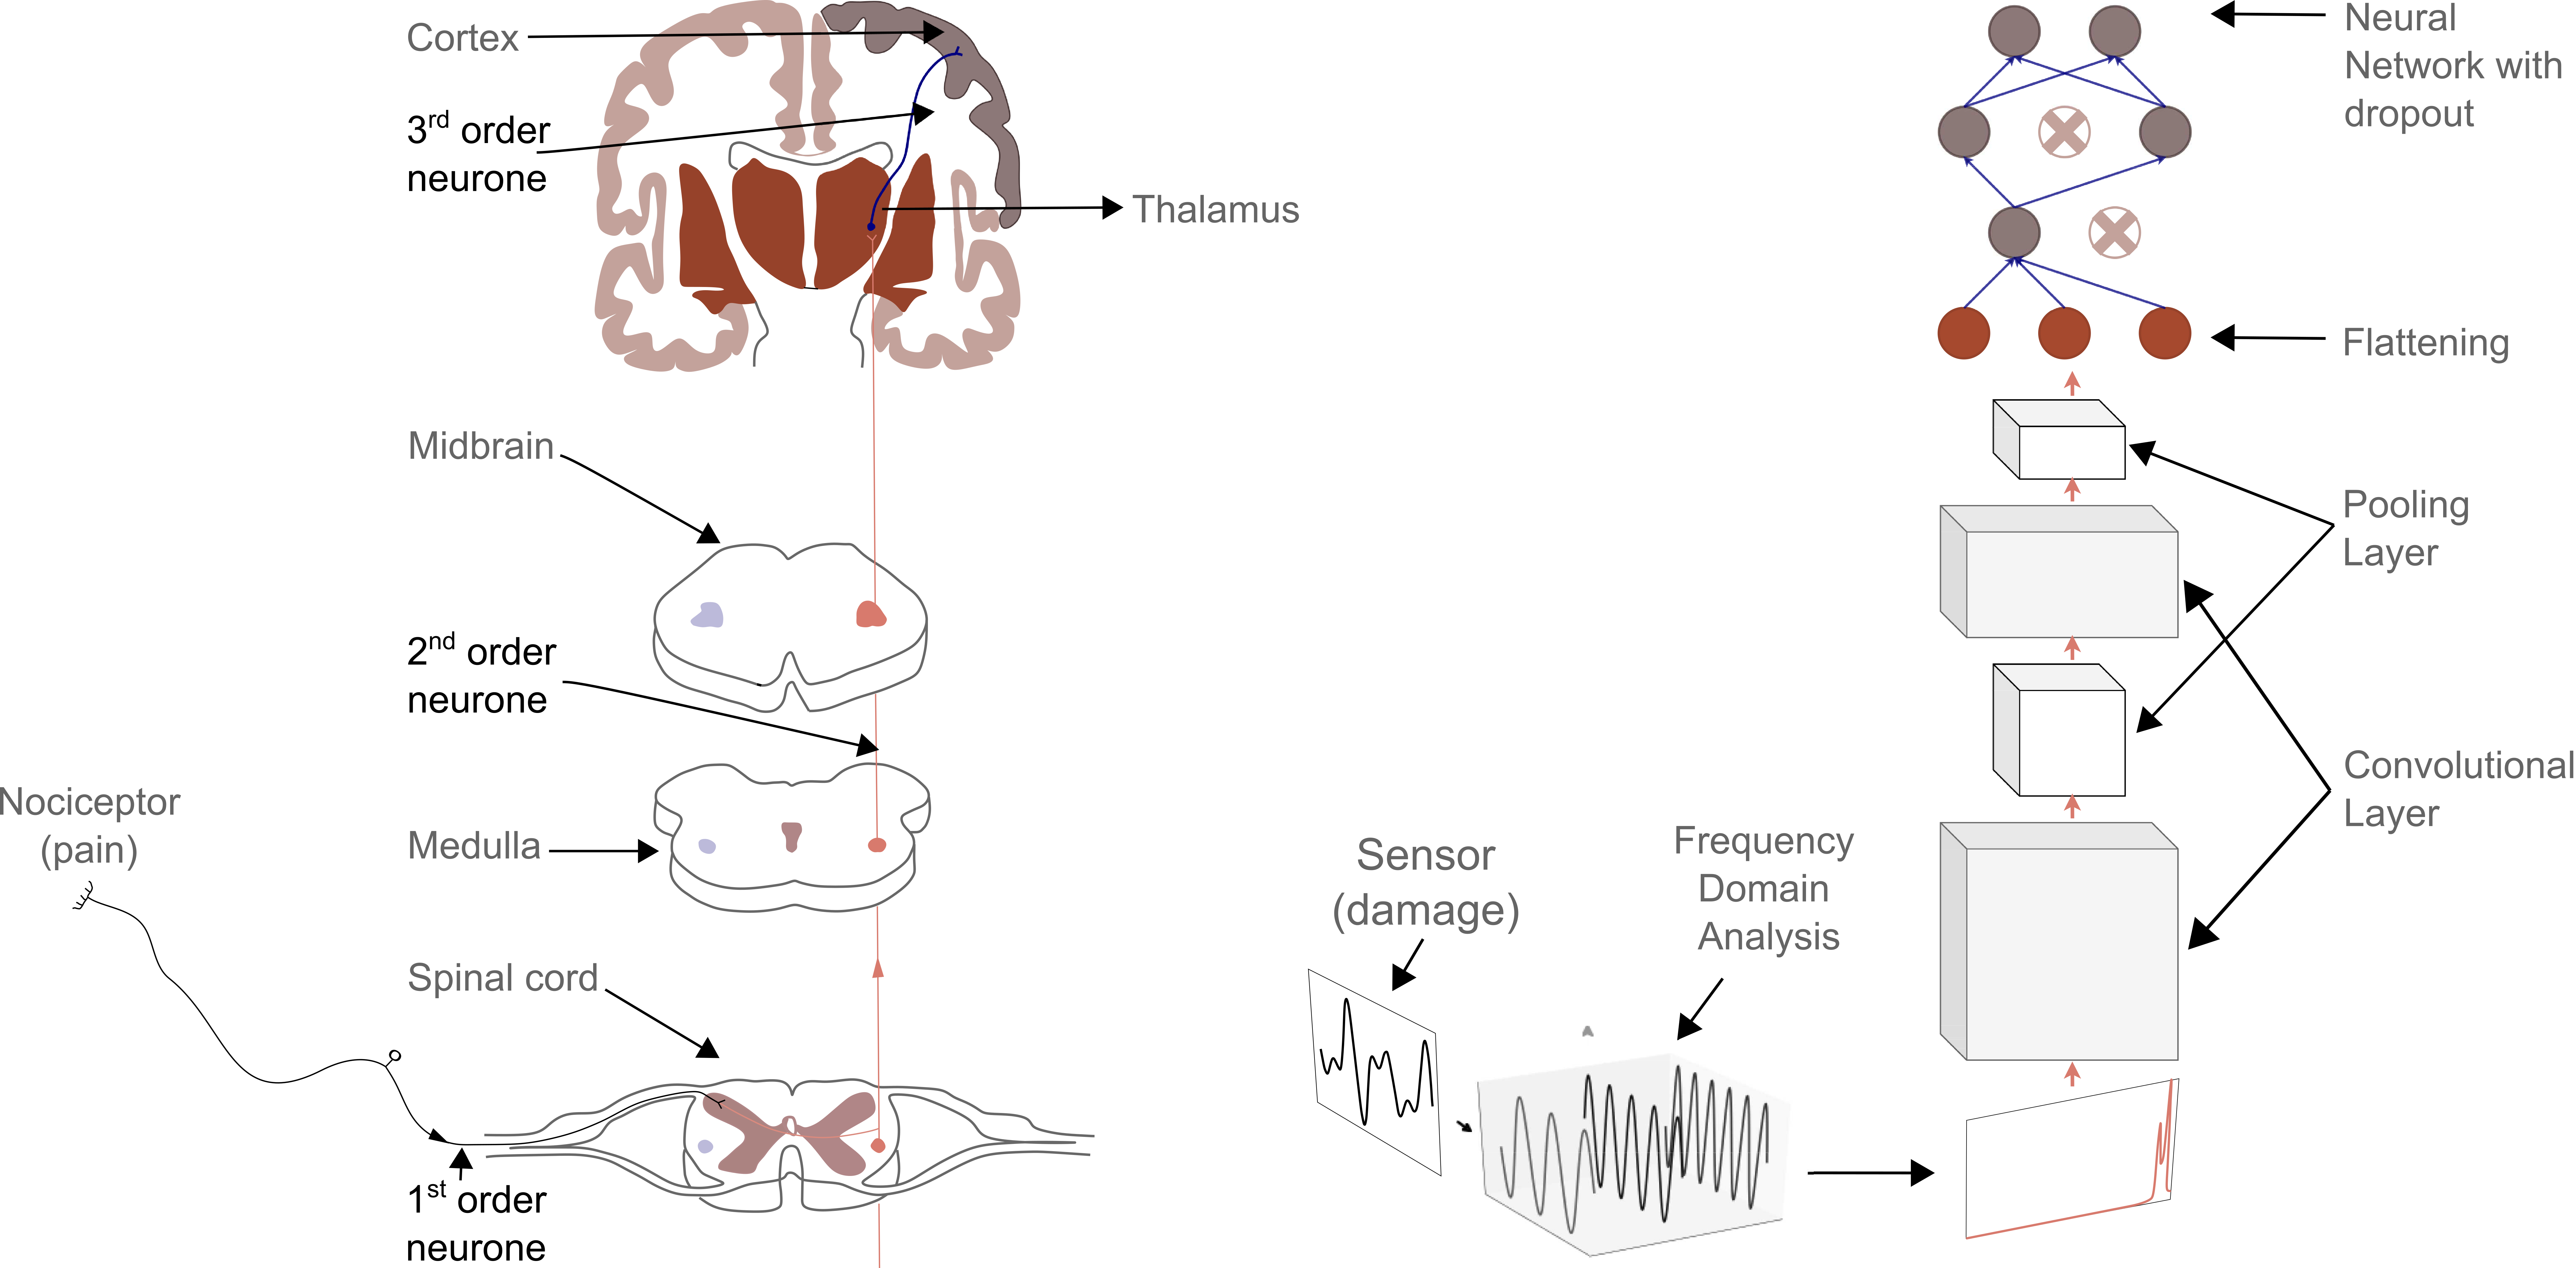


Figure 1 (Left): Simplified depiction of three sensory neurones carrying pain information through ascending signaling pathway (adapted from [31, 32])

Figure 2 (Right): Artificial Pain Pathway represented by three orders of layers, namely:
the periodogram method, convolutional layers and fully connected layer

In [4]:
# Please don't delete this flis from the Dropbox -Drone Pilot
r = !wget -O Vibration_T50.pkl.zip https://www.dropbox.com/s/ztpudrsjd64g5xt/Vibration_T50.pkl.zip?dl=0

# Even though The above warning someone will definetely delete or replace the above file. So when when that happens, please uncomment the following, I also copied (or hide :) ) the file in the following link
# r = !wget -O Vibration_T50.pkl.zip https://www.dropbox.com/s/4qku19u6ec3klq4/Vibration_T50.pkl.zip?dl=0

In [6]:
# Libraries used in the APP framework

import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib import cm
import math
import numpy as np
from scipy.signal import  welch
from scipy import stats
import matplotlib.dates as mdates
from keras.models import Sequential
from tensorflow.keras.utils import normalize
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from sklearn.model_selection import train_test_split
import zipfile
import matplotlib.ticker as ticker


In [7]:
# Unzipping the downloaded file
with zipfile.ZipFile('Vibration_T50.pkl.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [9]:
import pickle
with open('Vibration_T50.pkl', 'rb') as f:
    data = pickle.load(f)

In [10]:
# labels in T50 data set
labelIndex=["Time",  "Acc", "Gyro" ]
axisIndex=["X", "Y", "Z"]
SensorArr=['Gear box',
'Aluminum frame, front',
'Tail',
'Electronics box',
'Inside fuselage front',
'VECTOR',
'Bottom of landing gear']  


# From Matlab time format 2 Python Format
def matlab_to_python_datetime(matlab_datenum):
    return datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)


def matlab_to_python_datetime1(x):
    xN=[]
    for i in range(len(x)):
        xN.append(matlab_to_python_datetime(float(x[i])) )
    return xN

# Only the auto pilot (Vector) is used in this work
sensorVar =  [6] #          range(1,8)  

""" Removing the outliers by interpolating """
for SensN in sensorVar:
        for label in labelIndex:
            if label != "Time":
                for axis in axisIndex: 
                    for i in range(1,5):
                        mask = (np.abs(stats.zscore(data['FL'][str(i)]["Sensor_"+str(SensN)][label][axis])) > 3.5)
                        data['FL'][str(i)]["Sensor_"+str(SensN)][label][axis]= pd.DataFrame(data['FL'][str(i)]["Sensor_"+str(SensN)][label][axis]).mask(mask).interpolate()
  

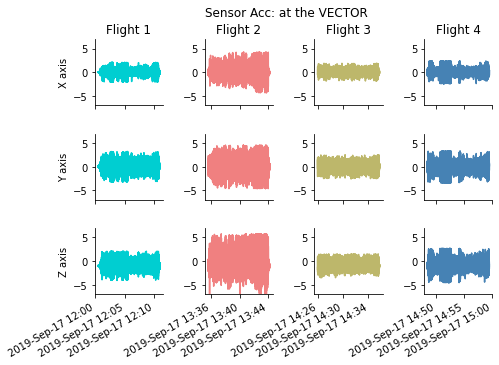

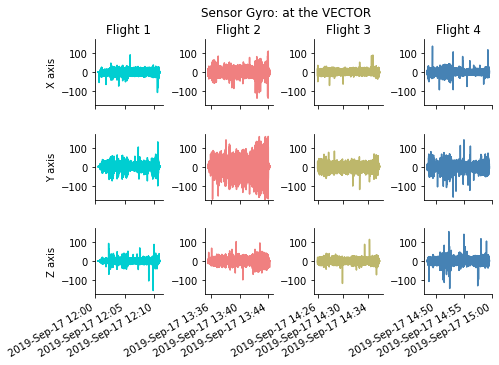

In [11]:
# Raw Data Plotting, if you like you can modify the code below and get the data for other sensors
color_map = ['darkturquoise','lightcoral','darkkhaki','steelblue']

for label in labelIndex[1:]:
    fig, axs = plt.subplots(3, 4,figsize=[6.25, 5])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle( "Sensor " + label + ': at the VECTOR',y=1)
    i=0
    for axis in axisIndex:
        for flight in range(4):
            axs[i//4, i%4].plot(matlab_to_python_datetime1(data['FL'][str(flight+1)]["Sensor_"+str(6)]["Time"]), data['FL'][str(flight+1)]["Sensor_"+str(6)][label][axis].values.tolist(),c=color_map[flight])
            plt.gcf().autofmt_xdate()
            ax = plt.gca()
            formatter = mdates.DateFormatter('%Y-%b-%d %H:%M')
            axs[i//4, i%4].xaxis.set_major_formatter(formatter)     
            axs[i//4, i%4].set_xticks(axs[i//4, i%4].get_xticks()[::4]) if flight in [1,2]  else axs[i//4, i%4].set_xticks(axs[i//4, i%4].get_xticks()[::1])
            axs[i//4, i%4].set_ylim((-7,7)) if label=='Acc' else axs[i//4, i%4].set_ylim((-175,175))
            axs[i//4, i%4].set_ylabel(axis + " axis") if flight == 0  else None
            axs[i//4, i%4].set_title("Flight " + str(flight+1)) if axis == "X" else None
            axs[i//4, i%4].spines['top'].set_visible(False)
            axs[i//4, i%4].spines['right'].set_visible(False)
            i+=1
    plt.savefig("Raw_"+label+".svg", bbox_inches = 'tight', pad_inches = 0)
    plt.show()

In [14]:
wS = 100
N_rem=2000 # Number of take off and landing data steps to be removed    

def prepareWelch(data, num, wS): 
    x={}
    
    for sens   in labelIndex[1:]:
        for axis in axisIndex: 
            x[sens+axis] = data['FL'][str(num)]["Sensor_"+str(6)][sens][axis][3 * N_rem:-N_rem] # N_rem and -N_rem means removing take off and landing data
    freqs, Pxx_spec = welch(x['AccX'][0:wS].transpose(),noverlap=0)
    num1,numX = math.floor((len(x['AccX'])-wS)/wS),len(Pxx_spec[0]) # dimensions of Input data
    X_all = np.zeros((num1, numX,6)) # Creating Welch Input data for the 1D CNN
    X_allF = np.zeros((num1, numX,6)) # Creating Welch Input data for the 1D CNN
    X_allR = np.zeros((num1, wS,6))  # Keeping the rawdata as Input data for the 1D CNN
    count=0
    for sens in labelIndex[1:]:
        for axis in axisIndex:          
            for c in range(num1):
                k_data=x[sens+axis][c*wS:(c*wS)+wS].fillna(0)           
                X_allR[c, : , count] = k_data.transpose()
                freqs, Pxx_spec = welch(k_data.transpose(),noverlap=0)
                X_all[c, : ,count]=Pxx_spec[0]
                X_allF[c, : , count]=freqs
            count+=1
    y_valid = np.zeros((len(X_all),2))
    if num==2: y_valid[:,1]=1
    else: y_valid[:,0]=1
    return X_all,X_allF,y_valid,X_allR

X1,XF1,y1,XR1 = prepareWelch(data, 1, wS)
X2,XF2,y2,XR2 = prepareWelch(data, 2, wS)
X3,XF3,y3,XR3 = prepareWelch(data, 3, wS)
X4,XF4,y4,XR4 = prepareWelch(data, 4, wS)

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  .format(nperseg, input_length))


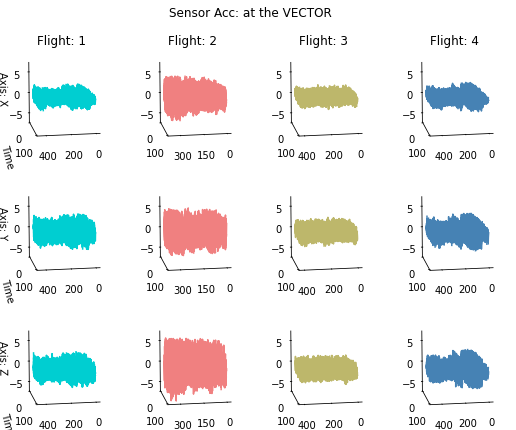

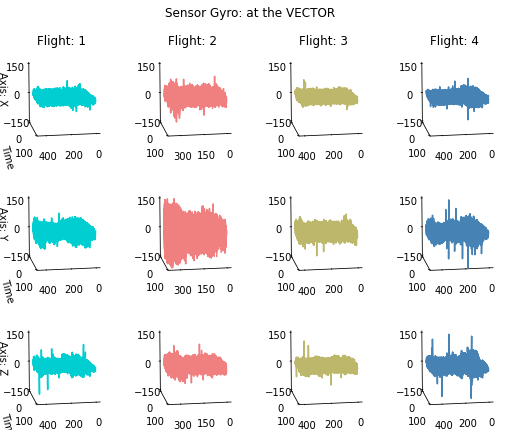

In [13]:
# Figure Raw Segmented

#for label in range(1,3):
for label in labelIndex[1:]:
    fig = plt.figure(figsize=[ 9, 7])
    fig.suptitle( "Sensor " + label + ': at the VECTOR', y=.95)
    i=0
    
    ai=0
    for axis in axisIndex:  
        for flight in range(1,5):
            i+=1
            ax = fig.add_subplot(3, 4, i, projection='3d')
            ax.view_init(10, 80)
            ax.set_title("Flight: "+ str(flight ))  if axis=="X" else None
            ax.set_xlabel('Segment No.')    if axis=="Z" else None
            ax.set_ylabel('Time',rotation=-75) if flight == 1 else None
            ax.set_zlabel("Axis: " + axis,labelpad=3) if flight == 1  else None
            ax.zaxis.set_label_coords(0,0,20)
            # make the panes transparent
            ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            
            # make the grid lines transparent
            ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
            ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
            ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
            
            ax.patch.set_facecolor(None)
            ax.patch.set_alpha(0)

            #ax.set_yticks(np.arange(0,250,150))
            #ax.set_xticks(np.arange(0,255,125))
            ax.set_zticks(np.arange(-5,6,5)) if label=='Acc' else ax.set_zticks(np.arange(-150,151,150))
            
            #ax.set_title("Flight: "+str(flight)+", Sensor: "+label+" at the "+SensorArr[SensN-1]+', Axis: '+axis )
            ax.set_zlim((-7,7)) if label=='Acc' else ax.set_zlim((-150,150))
            X_chang = eval('XR'+str(flight))
            ax.set_xticks(np.arange(0,len(X_chang)+1,200)) if flight !=2 else ax.set_xticks(np.arange(0,len(X_chang)+1,150))
            ax.set_yticks(np.arange(0,101,100))
            for c in range(len(X_chang)):
                Pxx_spec=X_chang[c][:,ai] if label=='Acc' else X_chang[c][:,ai+3] 
                ax.plot(xs= np.ones(len(Pxx_spec))*c, ys=range(len(Pxx_spec)), zs=Pxx_spec, c=color_map[flight-1],marker=None)
        ai+=1
    #plt.tight_layout(pad =1)
    plt.savefig("Raw_Segmented_"+label+".svg", bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    

    

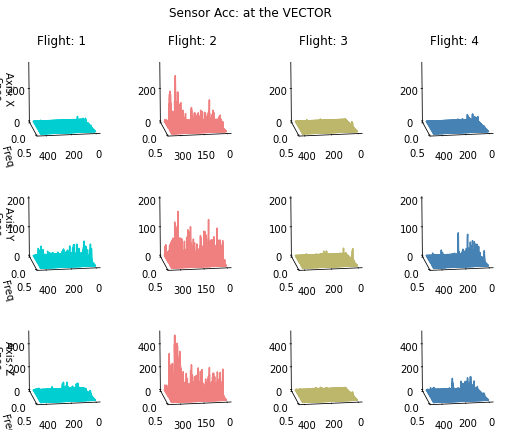

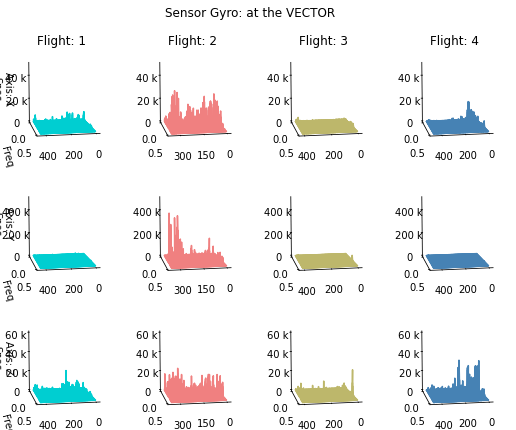

In [15]:
# Figure Welch Segmented
welchZlimits=[350,200,500,50000,500000,60000]
for label in labelIndex[1:]:
    fig = plt.figure(figsize=[9, 7])
    fig.suptitle( "Sensor " + label + ': at the VECTOR',y=.95)
    i=0
    ai=0
    for axis in axisIndex:
        for flight in range(1,5): 
            i+=1
            ax = fig.add_subplot(3, 4, i, projection='3d')
            ax.view_init(10, 80)
            ax.set_title("Flight: "+ str(flight ))  if axis=="X" else None
            ax.set_xlabel('Segment No.')    if axis=="Z" else None
            ax.set_ylabel('Freq',rotation=-75) if flight == 1 else None
            ax.zaxis.set_label_coords(0,0,20)
            ax.set_zlabel("Axis: " + axis + "\n"+"Spec",labelpad=3) if flight == 1  else None
            
            # make the panes transparent
            ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            
            # make the grid lines transparent
            ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
            ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
            ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
            
            ax.patch.set_facecolor(None)
            ax.patch.set_alpha(0)
            
            #ax.set_yticks(np.arange(0,76,75))
            #ax.set_xticks(np.arange(0,251,125))
            #ax.set_zticks(np.arange(0,welchZlimits[(i-1)%3]+1,welchZlimits[(i-1)%3]/2)) if label=='Acc' else ax.set_zticks(np.arange(0,welchZlimits[((i-1)%3)+3]+1,welchZlimits[((i-1)%3)+3]/2))

            ax.set_zlim((0,welchZlimits[(ai)%4])) if label=='Acc' else ax.set_zlim((0,welchZlimits[((ai)%4)+3]))
            ax.zaxis.set_major_formatter(ticker.EngFormatter())
            X_chang = eval('X'+str(flight))
            ax.set_xticks(np.arange(0,len(X_chang)+1,200)) if flight !=2 else ax.set_xticks(np.arange(0,len(X_chang)+1,150))
            ax.set_yticks(np.arange(0,0.51,0.5))
            for c in range(len(X_chang)):
                Pxx_spec=X_chang[c][:,ai] if label=='Acc' else X_chang[c][:,ai+3] 
                ax.plot(xs= np.ones(len(Pxx_spec))*c, ys=XF1[0][:,1], zs=Pxx_spec, c=color_map[flight-1],marker=None)
        ai+=1
    #plt.tight_layout(pad =-2)
    
    plt.savefig("Raw_Welch_"+label+".svg", bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    

In [16]:
# Data normalized before the tensorflow training
X_all = normalize(np.concatenate((X1, X2, X3, X4), axis=0),axis=0)
y_valid = np.concatenate((y1, y2, y3, y4), axis=0)
numX= len(X_all[0,:,0])
X_train, X_test, y_train, y_test = train_test_split(X_all, y_valid, test_size=0.5, random_state=42)


In [17]:
# Note: TF is significanly faster than the Keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


model = models.Sequential()
model.add(layers.Conv1D(32,  3, activation='relu', input_shape=( numX, 6 )))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())                             
model.add(layers.Dropout(0.6))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.6))

model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.6))

model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.7 ))
model.add(layers.Dense(2))
model.add(layers.Activation('sigmoid'))
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.MSE,
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 49, 32)            608       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               76900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1

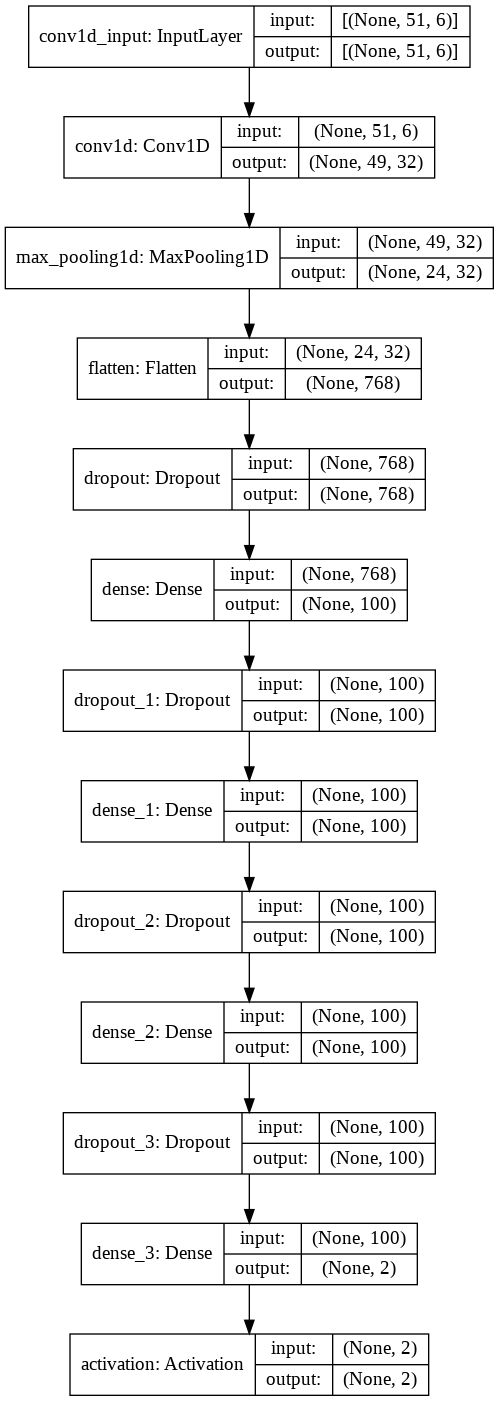

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="TB")



In [19]:
nb_epoch=25
model.fit(X_train, y_train, epochs=nb_epoch, validation_data=(X_test, y_test), batch_size = 1)


Epoch 1/25
837/837 [==============================] - 3s 3ms/step - loss: 0.1725 - accuracy: 0.7826 - val_loss: 0.1333 - val_accuracy: 0.7888
Epoch 2/25
837/837 [==============================] - 2s 3ms/step - loss: 0.1276 - accuracy: 0.8065 - val_loss: 0.0788 - val_accuracy: 0.8866
Epoch 3/25
837/837 [==============================] - 2s 3ms/step - loss: 0.0983 - accuracy: 0.8805 - val_loss: 0.0633 - val_accuracy: 0.9105
Epoch 4/25
837/837 [==============================] - 2s 3ms/step - loss: 0.0733 - accuracy: 0.9140 - val_loss: 0.0504 - val_accuracy: 0.9332
Epoch 5/25
837/837 [==============================] - 2s 3ms/step - loss: 0.0619 - accuracy: 0.9235 - val_loss: 0.0445 - val_accuracy: 0.9415
Epoch 6/25
837/837 [==============================] - 2s 3ms/step - loss: 0.0578 - accuracy: 0.9331 - val_loss: 0.0402 - val_accuracy: 0.9499
Epoch 7/25
837/837 [==============================] - 2s 3ms/step - loss: 0.0586 - accuracy: 0.9307 - val_loss: 0.0351 - val_accuracy: 0.9523
Epoch 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


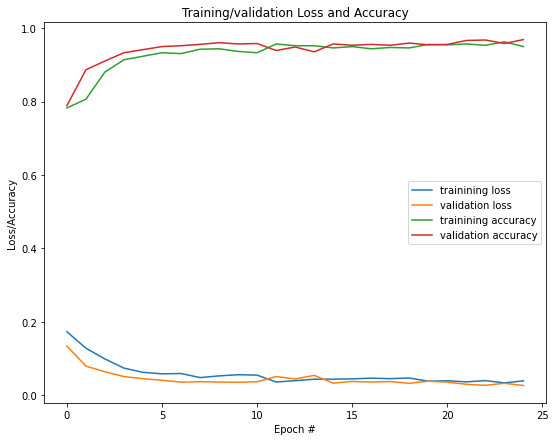

In [20]:
H= model.history

N = nb_epoch

fig = plt.figure(figsize=[ 9, 7])
plt.plot(np.arange(0, N), H.history["loss"], label="trainining loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="validation loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="trainining accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.title("Training/validation Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("app_acc_loss.eps", bbox_inches = 'tight', pad_inches = 0)
plt.show()



In [21]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = np.argmax(model.predict(X_all), axis=1)
print(classification_report(y_valid[:,1], y_pred))




              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1320
         1.0       0.95      0.92      0.94       355

    accuracy                           0.97      1675
   macro avg       0.97      0.96      0.96      1675
weighted avg       0.97      0.97      0.97      1675



In [22]:
print(confusion_matrix(y_valid[:,1], y_pred))


[[1303   17]
 [  27  328]]


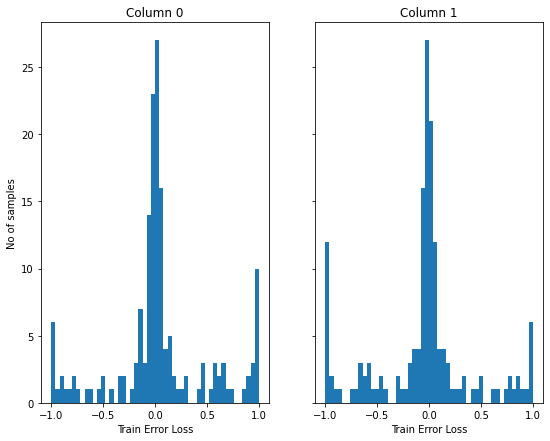

In [23]:
train_mae_loss = model.predict(X_all)[:,0]-y_valid[:,0]
train_mae_loss1 = model.predict(X_all)[:,1]-y_valid[:,1]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(9,7))
ax1.set_ylabel("No of samples")
ax1.set_xlabel("Train Error Loss")
ax1.hist(train_mae_loss[ np.where(abs(train_mae_loss)>=0.01) ], bins=50)
ax2.hist(train_mae_loss1[ np.where(abs(train_mae_loss1)>=0.01) ], bins=50)
ax2.set_xlabel("Train Error Loss")
ax1.set_title('Column 0')
ax2.set_title('Column 1')
plt.savefig("hist_mae.eps", bbox_inches = 'tight', pad_inches = 0)
plt.show()


# REFERENCES

[1] Hopfield, John J. ”Neural networks and physical systems with emergent
collective computational abilities.” Proceedings of the national academy
of sciences 79, no. 8 (1982): 2554-2558.

[2] Goller, Christoph, and Andreas Kuchler. ”Learning task-dependent distributed representations by backpropagation through structure.” In Proceedings of International Conference on Neural Networks (ICNN’96),
vol. 1, pp. 347-352. IEEE, 1996.

[3] Hochreiter, Sepp, and Jurgen Schmidhuber. ”Long short-term memory.” ¨
Neural computation 9, no. 8 (1997): 1735-1780.

[4] Sak, Hasim, Andrew W. Senior, and Franc¸oise Beaufays. ”Long shortterm memory recurrent neural network architectures for large scale acoustic modeling.” (2014).

[5] Tai, Kai Sheng, Richard Socher, and Christopher D. Manning. ”Improved
semantic representations from tree-structured long short-term memory
networks.” arXiv preprint arXiv:1503.00075 (2015).

[6] LeCun, Yann, Leon Bottou, Yoshua Bengio, and Patrick Ha ´ ffner.
”Gradient-based learning applied to document recognition.” Proceedings
of the IEEE 86, no. 11 (1998): 2278-2324.

[7] Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. ”Imagenet
classification with deep convolutional neural networks.” Advances in neural information processing systems 25 (2012): 1097-1105.

[8] Simonyan, Karen, and Andrew Zisserman. ”Very deep convolutional networks for large-scale image recognition.” arXiv preprint arXiv:1409.1556
(2014).

[9] Szegedy, Christian, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed,
Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, and Andrew
Rabinovich. ”Going deeper with convolutions.” In Proceedings of the
IEEE conference on computer vision and pattern recognition, pp. 1-9.
2015.

[10] Chollet, Franc¸ois. ”Xception: Deep learning with depthwise separable
convolutions.” In Proceedings of the IEEE conference on computer vision
and pattern recognition, pp. 1251-1258. 2017.

[11] Ackley, David H., Geoffrey E. Hinton, and Terrence J. Sejnowski. ”A
learning algorithm for Boltzmann machines.” Cognitive science 9, no. 1
(1985): 147-169.

[12] Salakhutdinov, Ruslan, Andriy Mnih, and Geoffrey Hinton. ”Restricted
Boltzmann machines for collaborative filtering.” In Proceedings of the
24th international conference on Machine learning, pp. 791-798. 2007.

[13] Salakhutdinov, Ruslan, and Geoffrey Hinton. ”Deep boltzmann machines.” In Artificial intelligence and statistics, pp. 448-455. PMLR, 2009.

[14] Nair, Vinod, and Geoffrey E. Hinton. ”Rectified linear units improve restricted boltzmann machines.” In Icml. 2010.

[15] Hinton, Geoffrey E. ”A practical guide to training restricted Boltzmann
machines.” In Neural networks: Tricks of the trade, pp. 599-619. Springer,
Berlin, Heidelberg, 2012.

[16] Hinton, Geoffrey E., and Richard S. Zemel. ”Autoencoders, minimum
description length, and Helmholtz free energy.” Advances in neural information processing systems 6 (1994): 3-10.

[17] Baldi, Pierre. ”Autoencoders, unsupervised learning, and deep architectures.” In Proceedings of ICML workshop on unsupervised and transfer
learning, pp. 37-49. JMLR Workshop and Conference Proceedings, 2012.

[18] Vincent, Pascal, Hugo Larochelle, Yoshua Bengio, and Pierre-Antoine
Manzagol. ”Extracting and composing robust features with denoising autoencoders.” In Proceedings of the 25th international conference on Machine learning, pp. 1096-1103. 2008.

[19] Hinton, Geoffrey E., Alex Krizhevsky, and Sida D. Wang. ”Transforming
auto-encoders.” In International conference on artificial neural networks,
pp. 44-51. Springer, Berlin, Heidelberg, 2011.

[20] Saha, B., Goebel, K., Poll, S., Christophersen, J. (2008). Prognostics
methods for battery health monitoring using a Bayesian framework. IEEE
Transactions on instrumentation and measurement, 58(2), 291-296.

[21] Vincent, Pascal, Hugo Larochelle, Isabelle Lajoie, Yoshua Bengio, PierreAntoine Manzagol, and Leon Bottou. ”Stacked denoising autoencoders: Learning useful representations in a deep network with a local denoising
criterion.” Journal of machine learning research 11, no. 12 (2010).

[22] EU Commission. ”Commission Implementing Regulation (EU) 2019/947
of 24 May 2019 on the rules and procedures for the operation of unmanned aircraft.” Official Journal of the European Union (2019).

[23] EU Commission. ”Commission Delegated Regulation (EU) 2019/945 of
12 March 2019 on unmanned aircraft systems and on third-country operators of unmanned aircraft systems” Official Journal of the European
Union (2019).

[24] la Cour-Harbo, Anders. ”The value of step-by-step risk assessment for
unmanned aircraft.” In 2018 International Conference on Unmanned Aircraft Systems (ICUAS), pp. 149-157. IEEE, 2018.

[25] IASP (n.d.). ”IASP Terminology, [website]”.
Retrieved 2021-02-08, from https://www.iasppain.org/Education/Content.aspx?ItemNumber=1698Pain

[26] Merskey, Harold. ”Part III pain terms, a current list with definitions and
notes on usage.” Classification of chronic pain-descriptions of chronic
pain syndromes and definitions of pain terms (1994): 207-214.

[27] Watson, Jennv. ”Pain Mechanisms—A review: II. Afferent pain pathways.” Australian Journal of Physiotherapy 27, no. 6 (1981): 191-198.

[28] Cross, Shelley A. ”Pathophysiology of pain.” In Mayo Clinic Proceedings, vol. 69, no. 4, pp. 375-383. Elsevier, 1994.

[29] Willis, William D., Elie D. Al-Chaer, Michael J. Quast, and Karin N.
Westlund. ”A visceral pain pathway in the dorsal column of the spinal
cord.” Proceedings of the National Academy of Sciences 96, no. 14
(1999): 7675-7679.

[30] Almeida, Tatiana F., Suely Roizenblatt, and Sergio Tufik. ”Afferent pain
pathways: a neuroanatomical review.” Brain research 1000, no. 1-2
(2004): 40-56.

[31] Godfrey, Helen. ”Understanding pain, part 1: physiology of pain.” British
Journal of Nursing 14, no. 16 (2005): 846-852.

[32] Godfrey, Helen. ”Understanding pain, part 2: pain management.” British
journal of nursing 14, no. 17 (2005): 904-909.

[33] Gold, Jeffrey I., Katharine A. Belmont, and David A. Thomas. ”The neurobiology of virtual reality pain attenuation.” CyberPsychology Behavior
10, no. 4 (2007): 536-544.

[34] Cioffi, Christopher L. ”Modulation of glycine-mediated spinal neurotransmission for the treatment of chronic pain.” Journal of medicinal
chemistry 61, no. 7 (2017): 2652-2679.

[35] Welch, Peter. ”The use of fast Fourier transform for the estimation of
power spectra: a method based on time averaging over short, modified
periodograms.” IEEE Transactions on audio and electroacoustics 15, no.
2 (1967): 70-73.

[36] Bechhoefer, Eric, Brandon Van Hecke, and David He. ”Processing for
improved spectral analysis.” In Annual conference of the prognostics and
health management society, pp. 14-17. 2013.

[37] Saidi, Lotfi, Jaouher Ben Ali, Eric Bechhoefer, and Mohamed Benbouzid.
”Wind turbine high-speed shaft bearings health prognosis through a spectral Kurtosis-derived indices and SVR.” Applied Acoustics 120 (2017):
1-8.

[38] Ali, Jaouher Ben, Lotfi Saidi, Salma Harrath, Eric Bechhoefer, and Mohamed Benbouzid. ”Online automatic diagnosis of wind turbine bearings
progressive degradations under real experimental conditions based on unsupervised machine learning.” Applied Acoustics 132 (2018): 167-181.

[39] Zhang, Liangwei, Jing Lin, Bin Liu, Zhicong Zhang, Xiaohui Yan, and
Muheng Wei. ”A review on deep learning applications in prognostics and
health management.” IEEE Access 7 (2019): 162415-162438.

[40] Abdeljaber, Osama, Onur Avci, Serkan Kiranyaz, Moncef Gabbouj, and
Daniel J. Inman. ”Real-time vibration-based structural damage detection
using one-dimensional convolutional neural networks.” Journal of Sound
and Vibration 388 (2017): 154-170.

[41] Ince, Turker, Serkan Kiranyaz, Levent Eren, Murat Askar, and Moncef
Gabbouj. ”Real-time motor fault detection by 1-D convolutional neural
networks.” IEEE Transactions on Industrial Electronics 63, no. 11 (2016):
7067-7075.

[42] Janssens, Olivier, Viktor Slavkovikj, Bram Vervisch, Kurt Stockman, Mia
Loccufier, Steven Verstockt, Rik Van de Walle, and Sofie Van Hoecke.
”Convolutional neural network based fault detection for rotating machinery.” Journal of Sound and Vibration 377 (2016): 331-345.

[43] Zhang, Wei, Gaoliang Peng, Chuanhao Li, Yuanhang Chen, and Zhujun
Zhang. ”A new deep learning model for fault diagnosis with good anti noise and domain adaptation ability on raw vibration signals.” Sensors 17,
no. 2 (2017): 425.

[44] Guo, Liang, Yaguo Lei, Naipeng Li, and Saibo Xing. ”Deep convolution
feature learning for health indicator construction of bearings.” In 2017
Prognostics and System Health Management Conference (PHM-Harbin),
pp. 1-6. IEEE, 2017.

[45] Bach-Andersen, Martin, Bo Rømer-Odgaard, and Ole Winther. ”Deep
learning for automated drivetrain fault detection.” Wind Energy 21, no.
1 (2018): 29-41.

[46] Bach-Andersen, Martin, Bo Rømer-Odgaard, and Ole Winther. ”Deep
learning for automated drivetrain fault detection.” Wind Energy 21, no.
1 (2018): 29-41.

[47] Guo, Mou-Fa, Xiao-Dan Zeng, Duan-Yu Chen, and Nien-Che Yang.
”Deep-learning-based earth fault detection using continuous wavelet
transform and convolutional neural network in resonant grounding distribution systems.” IEEE Sensors Journal 18, no. 3 (2018): 1291-1300.

[48] Li, Hongmei, Jinying Huang, and Shuwei Ji. ”Bearing fault diagnosis
with a feature fusion method based on an ensemble convolutional neural
network and deep neural network.” Sensors 19, no. 9 (2019): 2034.

[49] Al-Dulaimi, Ali, Soheil Zabihi, Amir Asif, and Arash Mohammadi. ”A
multimodal and hybrid deep neural network model for remaining useful
life estimation.” Computers in Industry 108 (2019): 186-196.

[50] Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I. and Salakhutdinov, R., 2014. Dropout: a simple way to prevent neural networks from
overfitting. The journal of machine learning research, 15(1), pp.1929-
1958.

[51] Hinton, G.E., Srivastava, N., Krizhevsky, A., Sutskever, I. and Salakhutdinov, R.R., 2012. Improving neural networks by preventing co-adaptation
of feature detectors. arXiv preprint arXiv:1207.0580.

[52] Barbe, Kurt, Rik Pintelon, and Johan Schoukens. ”Welch method revisited: nonparametric power spectrum estimation via circular overlap.”
IEEE Transactions on signal processing 58, no. 2 (2009): 553-565.

[53] Schuster, Arthur. ”On the investigation of hidden periodicities with application to a supposed 26 day period of meteorological phenomena.” Terrestrial Magnetism 3, no. 1 (1898): 13-41.

[54] Proakis, John G. Digital signal processing: principles algorithms and applications. Pearson Education India, 2001.

[55] Smith III, Juliu O. Spectral audio signal processing. W3K publishing,
2011.

[56] LeCun, Yann, Yoshua Bengio, and Geoffrey Hinton. ”Deep learning.” nature 521, no. 7553 (2015): 436-444.

[57] Lippmann, Richard P. ”An introduction to computing with neural nets.”
Artificial neural networks: theoretical concepts. IEEE Computer Society
Press, 1988.

[58] Goodfellow, I., Bengio, Y. and Courville, A., 2016. ”6.2.2.3 Softmax
Units for Multinoulli Output Distributions”. Deep Learning. MIT Press.
pp. 180–184. ISBN 978-0-26203561-3.

[59] UAS-ability. (n.d.). Home, [youtube channel]. Retrieved
2020-08-25, from https://www.youtube.com/channel/
UCwIUbrNZCwBuWZ4rRBUq3LA

[60] Kingma, D.P. and Ba, J., 2014. Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.